In [8]:
from tensorflow.keras.applications import VGG16
import ssl



In [9]:
ssl._create_default_https_context = ssl._create_unverified_context

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150,150,3))

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### Fast feature extraction without data augmentation

In [13]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
base_dir='/Users/amitjha/Downloads/cats_and_dogs_small'
train_dir =  os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir,'test')


In [15]:
data_gen = ImageDataGenerator(rescale = 1./255)
batch_size = 20


In [19]:
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count,4,4,512))
    labels = np.zeros(shape = (sample_count))
    generator = data_gen.flow_from_directory(
        directory,
        target_size = (150,150),
        batch_size = batch_size,
        class_mode = 'binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1)* batch_size] = features_batch
        labels[i * batch_size : (i+1)* batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [34]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_featues, validation_labels = extract_features(validation_dir, 1000)
test_featues, test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [35]:
train_features = np.reshape(train_features, (2000 , 4* 4* 512))
validation_featues = np.reshape(validation_featues, (1000 , 4* 4* 512))
test_featues = np.reshape(test_featues, (1000 , 4* 4* 512))


In [36]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [37]:
model = models.Sequential()
model.add(layers.Dense(256, activation= 'relu', input_dim = 4 * 4* 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [38]:
model.compile(optimizer = optimizers.RMSprop(lr = 2e-5), loss= 'binary_crossentropy', metrics = ['acc'])

In [39]:
train_features.shape

(2000, 8192)

In [40]:
history = model.fit(train_features, train_labels, 
                    epochs = 30, batch_size = 20, validation_data = (validation_featues,validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 6s 3ms/sample - loss: 0.6388 - acc: 0.6360 - val_loss: 0.4530 - val_acc: 0.8250
Epoch 2/30
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.4472 - acc: 0.7895 - val_loss: 0.3640 - val_acc: 0.8600
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.3675 - acc: 0.8505 - val_loss: 0.3251 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.3166 - acc: 0.8725 - val_loss: 0.3033 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.2984 - acc: 0.8760 - val_loss: 0.2844 - val_acc: 0.8840
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.2675 - acc: 0.8880 - val_loss: 0.2805 - val_acc: 0.8890
Epoch 7/30
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.2417 - acc: 0.9075 - val_loss: 0.2708 - val_acc: 0.8930


In [42]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and Validation Accuracy')

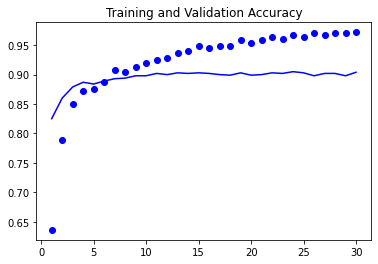

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc) +1)
plt.plot(epochs, acc, 'bo',label = 'Training acc')
plt.plot(epochs, val_acc, 'b',label = 'Validation acc')
plt.title('Training and Validation Accuracy')


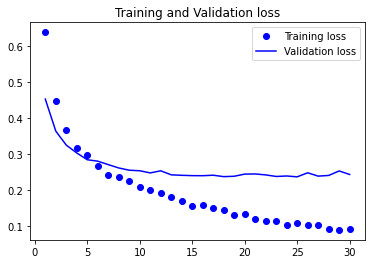

In [45]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [46]:
import tensorflow as tf

In [49]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0
